# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import json
from PIL import Image

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# local path to mapillary dataset
DATASET_DIR = os.path.join(ROOT_DIR, "mapillary_dataset")
DEV_DIR = os.path.join(DATASET_DIR, 'dev')
IMG_DIR = os.path.join(DEV_DIR, 'images')
INS_DIR = os.path.join(DEV_DIR, 'instances')

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/Users/shawlu/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class MapillaryConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "mapillary"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = MapillaryConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           mapillary
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
R

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class MapillaryDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    CLASS_MAP = {}
    CLASSES = ["Bird", "Person", "Bicyclist", "Motorcyclist", "Bench", "Car", "Person", "Fire Hydrant", "Traffic Light", "Bus", "Motorcycle", "Truck"]
    def load_mapillary(self, dataset_dir, subset, class_ids=None,
                  class_map=None):
        
        # generate classes
        class_id = 1
        for label_id, label in enumerate(class_ids):
            if label["instances"] == True and label["readable"] in self.CLASSES:
                self.CLASS_MAP[label_id] = class_id
                print("{}: Class {} {} added".format(label_id, class_id, label["readable"]))
                self.add_class("mapillary", class_id, label["readable"])
                class_id = class_id + 1
                
        # add images 
        file_names = next(os.walk(IMG_DIR))[2]
        for i in range(len(file_names)):
            image_path = os.path.join(IMG_DIR, file_names[i])
            base_image = Image.open(image_path)
            w, h = base_image.size
            print("Image {} {} x {} added".format(file_names[i], w, h))
            self.add_image("mapillary", image_id = i,
                          path = file_names[i],
                           width = w,
                           height = h
                          )

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        img_path = os.path.join(IMG_DIR, info["path"])
        base_image = Image.open(img_path)
        base_image_array = np.array(base_image)
        return base_image_array

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        img_path = os.path.join(IMG_DIR, info["path"])
        return img_path

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        instance_path = os.path.join(INS_DIR, info["path"])
        instance_image = Image.open(instance_path.rsplit(".", 1)[0] + ".png")
        
        # convert labeled data to numpy arrays for better handling
        instance_array = np.array(instance_image, dtype=np.uint16)

        instances = np.unique(instance_array)
        instaces_count = instances.shape[0]
        
        label_ids = instances // 256
        label_id_count = np.unique(label_ids).shape[0]
        
        print("There are {} instances, {} classes labelled instances in the image {}.".format(instaces_count, label_id_count, info["path"]))
        mask = np.zeros([instance_array.shape[0], instance_array.shape[1], instaces_count], dtype=np.uint8)
        mask_count = 0
        loaded_class_ids = []
        for instance in instances:
            label_id = instance//256
            if (label_id in self.CLASS_MAP):
                m = np.zeros((instance_array.shape[0], instance_array.shape[1]), dtype=np.uint8)
                m[instance_array == instance] = 1
                mask[:, :, mask_count] = m
                loaded_class_ids.append(self.CLASS_MAP[label_id])
                print("Mask {} created for instance {} of class {} {}".format(mask_count, instance, self.CLASS_MAP[label_id], self.class_names[self.CLASS_MAP[label_id]]))
                mask_count = mask_count + 1
        mask = mask[:, :, 0:mask_count]
        return mask, np.array(loaded_class_ids)

In [5]:
# read in config file
with open(os.path.join(DATASET_DIR, 'config.json')) as config_file:
    class_config = json.load(config_file)
# in this example we are only interested in the labels
labels = class_config['labels']
        
# Training dataset
dataset_train = MapillaryDataset()
dataset_train.load_mapillary(DATASET_DIR, "dev", class_ids = labels)
dataset_train.prepare()

# Validation dataset
dataset_val = MapillaryDataset()
dataset_val.load_mapillary(DATASET_DIR, "dev", class_ids = labels)
dataset_val.prepare()

print("mapping: ", class_config["mapping"])
print("version: ", class_config["version"])
print("folder_structure:", class_config["folder_structure"])
print("There are {} classes in the config file".format(len(labels)))
print("There are {} classes in the model".format(len(dataset_train.class_names)))

0: Class 1 Bird added
19: Class 2 Person added
20: Class 3 Bicyclist added
21: Class 4 Motorcyclist added
33: Class 5 Bench added
38: Class 6 Fire Hydrant added
48: Class 7 Traffic Light added
54: Class 8 Bus added
55: Class 9 Car added
57: Class 10 Motorcycle added
61: Class 11 Truck added
Image _7zhntDU5r1EmkFSuzKxaQ.jpg 3984 x 2988 added
Image __IoBfs3I6vB5ND-vqXK1A.jpg 3840 x 2160 added
0: Class 1 Bird added
19: Class 2 Person added
20: Class 3 Bicyclist added
21: Class 4 Motorcyclist added
33: Class 5 Bench added
38: Class 6 Fire Hydrant added
48: Class 7 Traffic Light added
54: Class 8 Bus added
55: Class 9 Car added
57: Class 10 Motorcycle added
61: Class 11 Truck added
Image _7zhntDU5r1EmkFSuzKxaQ.jpg 3984 x 2988 added
Image __IoBfs3I6vB5ND-vqXK1A.jpg 3840 x 2160 added
mapping:  public
version:  1.0
folder_structure: {split}/{content}/{key:.{22}}.{ext}
There are 66 classes in the config file
There are 12 classes in the model


There are 80 instances, 21 classes labelled instances in the image _7zhntDU5r1EmkFSuzKxaQ.jpg.
Mask 0 created for instance 4864 of class 2 Person
Mask 1 created for instance 4865 of class 2 Person
Mask 2 created for instance 9728 of class 6 Fire Hydrant
Mask 3 created for instance 9729 of class 6 Fire Hydrant
Mask 4 created for instance 9730 of class 6 Fire Hydrant
Mask 5 created for instance 12288 of class 7 Traffic Light
Mask 6 created for instance 12289 of class 7 Traffic Light
Mask 7 created for instance 12290 of class 7 Traffic Light
Mask 8 created for instance 12291 of class 7 Traffic Light
Mask 9 created for instance 12292 of class 7 Traffic Light
Mask 10 created for instance 12293 of class 7 Traffic Light
Mask 11 created for instance 14080 of class 9 Car
Mask 12 created for instance 14081 of class 9 Car
Mask 13 created for instance 14082 of class 9 Car
Mask 14 created for instance 14083 of class 9 Car
Mask 15 created for instance 14084 of class 9 Car
Mask 16 created for instanc

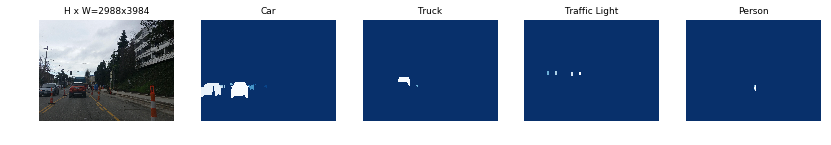

In [6]:
# Load and display one image
image_id = 0
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Text(0.5,1,'Car')

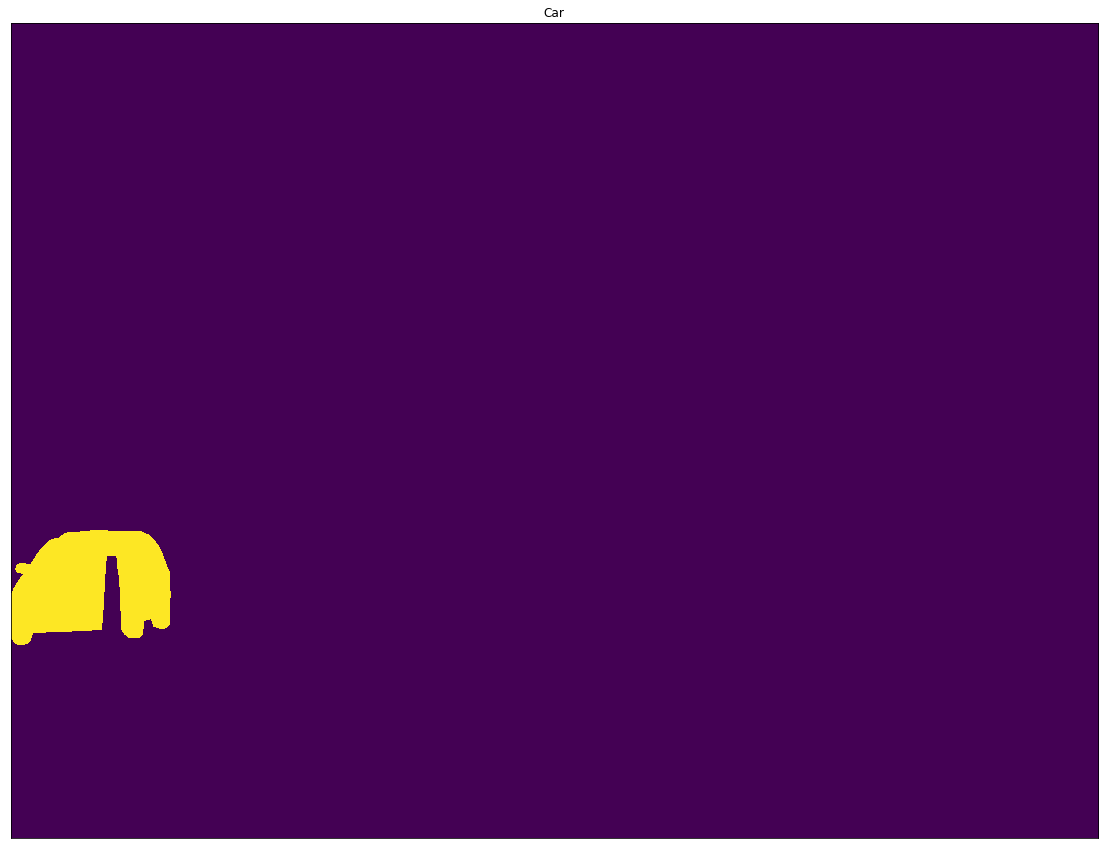

In [7]:
# visualize one mask (change the value of n)
n = 22

# plot a mask
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
ax.imshow(mask[:, :, n])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(dataset_train.class_names[class_ids[n]])

## Ceate Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all"` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"

# Load pretrained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# TODO: RESOLVE THE ERROR
# ValueError: Dimension 1 in both shapes must be equal, but are 16 and 324. Shapes are [1024,16] and [1024,324]. for 'Assign_2049' (op: 'Assign') with input shapes: [1024,16], [1024,324].

StopIteration: 

There are 80 instances, 21 classes labelled instances in the image _7zhntDU5r1EmkFSuzKxaQ.jpg.
Mask 0 created for instance 4864 of class 2 Person
Mask 1 created for instance 4865 of class 2 Person
Mask 2 created for instance 9728 of class 6 Fire Hydrant
Mask 3 created for instance 9729 of class 6 Fire Hydrant
Mask 4 created for instance 9730 of class 6 Fire Hydrant
Mask 5 created for instance 12288 of class 7 Traffic Light
Mask 6 created for instance 12289 of class 7 Traffic Light
Mask 7 created for instance 12290 of class 7 Traffic Light
Mask 8 created for instance 12291 of class 7 Traffic Light
Mask 9 created for instance 12292 of class 7 Traffic Light
Mask 10 created for instance 12293 of class 7 Traffic Light
Mask 11 created for instance 14080 of class 9 Car
Mask 12 created for instance 14081 of class 9 Car
Mask 13 created for instance 14082 of class 9 Car
Mask 14 created for instance 14083 of class 9 Car
Mask 15 created for instance 14084 of class 9 Car
Mask 16 created for instanc

/Users/shawlu/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


original_image           shape: (128, 128, 3)         min:    0.00000  max:  252.00000
image_meta               shape: (20,)                 min:    0.00000  max: 3984.00000
gt_class_id              shape: (26,)                 min:    2.00000  max:   11.00000
gt_bbox                  shape: (26, 4)               min:    0.00000  max:   90.00000
gt_mask                  shape: (128, 128, 26)        min:    0.00000  max:    1.00000


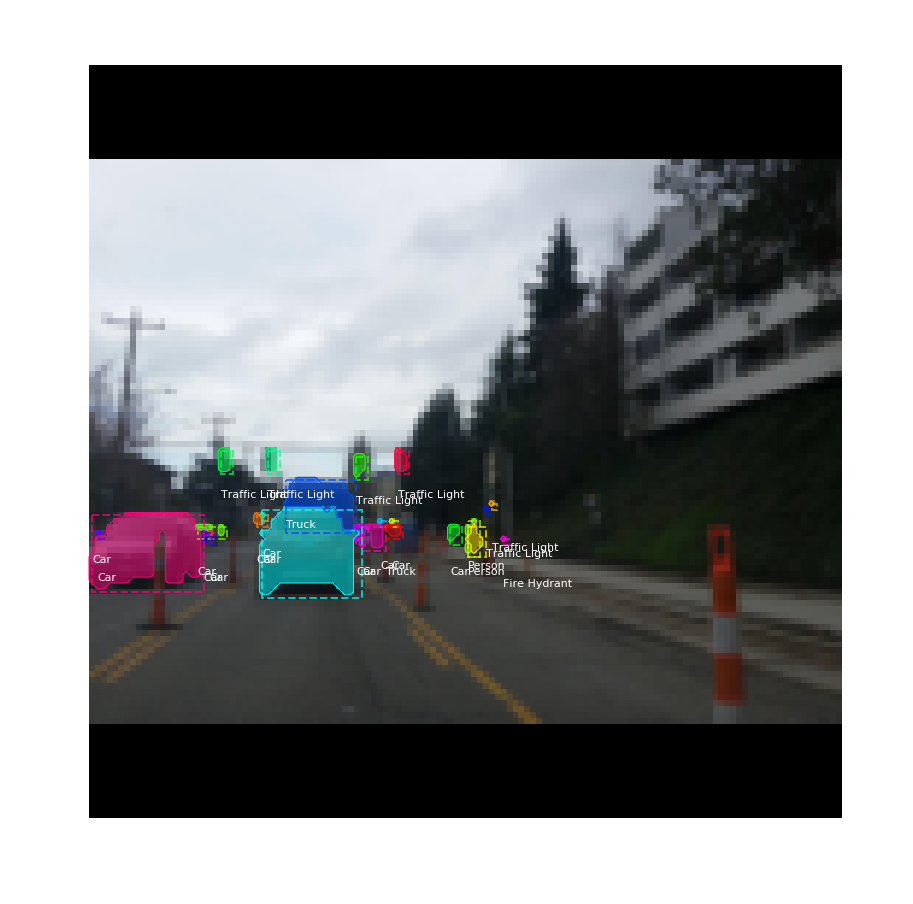

In [127]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)

# Pick a specific image
image_id = 0
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


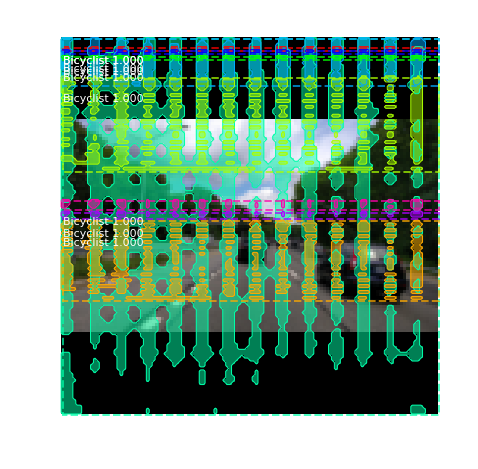

In [120]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [110]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 2)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

There are 48 instances, 18 classes labelled instances in the image.
Mask 0 created for instance 4864 of class 2 Person
Mask 1 created for instance 4865 of class 2 Person
Mask 2 created for instance 4866 of class 2 Person
Mask 3 created for instance 4867 of class 2 Person
Mask 4 created for instance 4868 of class 2 Person
Mask 5 created for instance 4869 of class 2 Person
Mask 6 created for instance 4870 of class 2 Person
Mask 7 created for instance 4871 of class 2 Person
Mask 8 created for instance 4872 of class 2 Person
Mask 9 created for instance 4873 of class 2 Person
Mask 10 created for instance 4874 of class 2 Person
Mask 11 created for instance 4875 of class 2 Person
Mask 12 created for instance 14080 of class 9 Car
Mask 13 created for instance 15616 of class 11 Truck


/Users/shawlu/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


There are 73 instances, 16 classes labelled instances in the image.
Mask 0 created for instance 14080 of class 9 Car
Mask 1 created for instance 14081 of class 9 Car
Mask 2 created for instance 14082 of class 9 Car
Mask 3 created for instance 14083 of class 9 Car
Mask 4 created for instance 14084 of class 9 Car
Mask 5 created for instance 14085 of class 9 Car
Mask 6 created for instance 14086 of class 9 Car
Mask 7 created for instance 14087 of class 9 Car
Mask 8 created for instance 14088 of class 9 Car
Mask 9 created for instance 14089 of class 9 Car
Mask 10 created for instance 14090 of class 9 Car
Mask 11 created for instance 14091 of class 9 Car
Mask 12 created for instance 14092 of class 9 Car
mAP:  0.0
